#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Общий вывод</a></span></li>

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import sklearn
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as scs
from scipy.optimize import minimize
from prophet import Prophet

In [2]:
df = pd.read_csv('/Users/kostyabykov/Downloads/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

print('is_monotonic:', df.index.is_monotonic)
print('min:', df.index.min())
print('max:', df.index.max())
df.head()

is_monotonic: True
min: 2018-03-01 00:00:00
max: 2018-08-31 23:50:00


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# Прверим наличие пропусков
print("Кол-во пропусков", df.isnull().sum())

Кол-во пропусков num_orders    0
dtype: int64


### Вывод
* Мы провели первоначальный анализ данных
* В датасете временной ряд начинается с 1 марта 2018 и оканчивается 31 августа 2018
* Данные расположены в хронологическом порядке, длина интервала равна 10 минутам
* Временной ряд был принят за индекс
* Пропуски отсутствуют

## Анализ

In [5]:
# Проведем ресемплирование по одному часу
df_1h = df.resample('1H').sum()
df_1d = df.resample('1D').sum()
df_1w = df.resample('1W').sum()
df_1m = df.resample('1M').sum()

In [6]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [7]:
df_2h = df_1h.copy()
df_2h['rolling_mean'] = df_2h.rolling(24).mean()
plotly_df(df_2h, title = "Кол-во заказов такси в разбивке по дням")

In [8]:
df_2d = df_1d.copy()
df_2d['rolling_mean'] = df_2d.rolling(7).mean()
plotly_df(df_2d, title = "Кол-во заказов такси в разбивке по дням")

In [9]:
df_2w = df_1w.copy()
df_2w['rolling_mean'] = df_2w.rolling(4).mean()
plotly_df(df_2w, title = "Кол-во заказов такси в разбивке по неделям")

In [10]:
df_2m = df_1m.copy()
df_2m['rolling_mean'] = df_2m.rolling(2).mean()
plotly_df(df_2m, title = "Кол-во заказов такси в разбивке по месяцам")

In [11]:
# Рассмотрим подробней тренды
df_2h = df_2h['2018-04-01':'2018-04-15']
plotly_df(df_2h, title = "Кол-во заказов такси 01 apr - 15 apr")

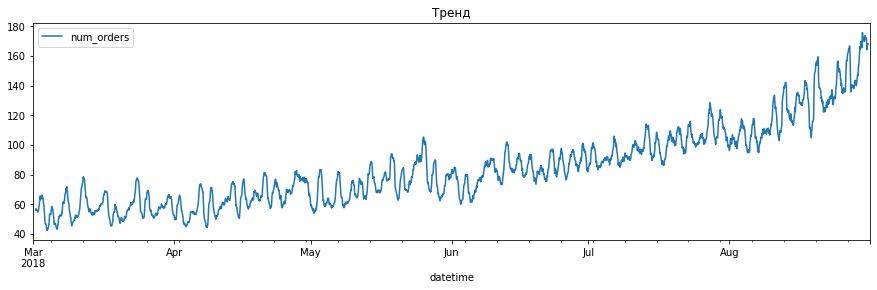

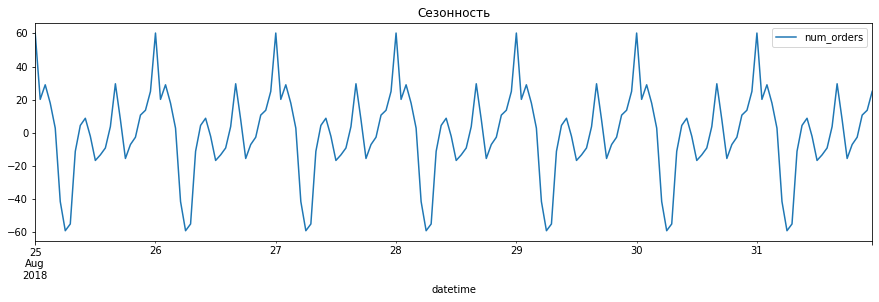

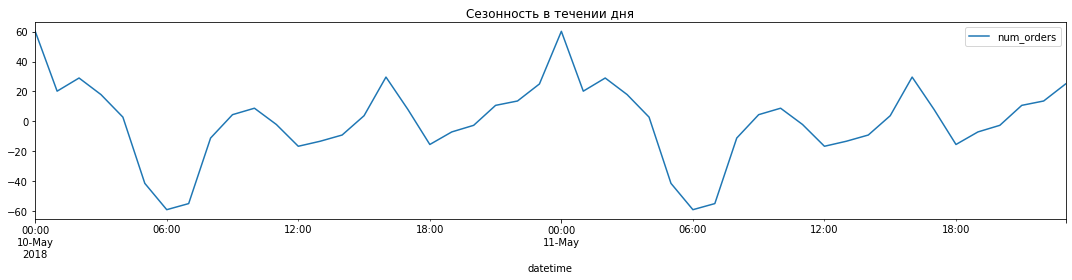

In [12]:
decomposed_df = seasonal_decompose(df_1h)
decomposed_df.trend.plot(title='Тренд', figsize=(15,4))
decomposed_df.seasonal.tail(24*7).plot(title='Сезонность', figsize=(15,4))
plt.figure(figsize=(15, 4))
decomposed_df.seasonal['2018-05-10':'2018-05-11'].plot(ax=plt.gca(), figsize=(15,4))
plt.title('Сезонность в течении дня')
plt.tight_layout()

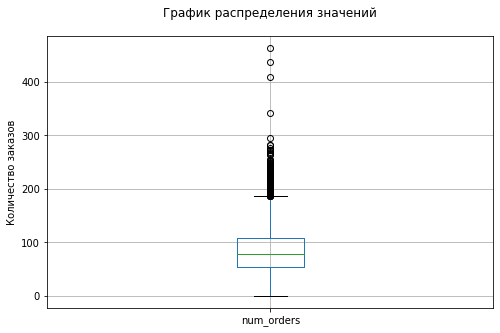

In [13]:
plt.figure(figsize=(8,5))
df_1h.boxplot('num_orders')
plt.title('График распределения значений', y=1.05)
plt.ylabel('Количество заказов')
plt.show()

In [14]:
df_1h.loc[df_1h['num_orders'] > 300]

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342


<AxesSubplot:xlabel='datetime'>

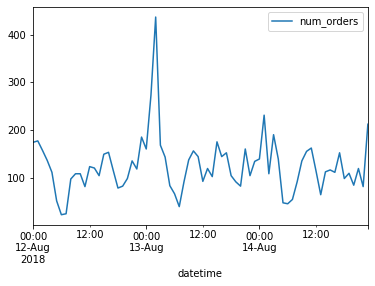

In [15]:
df_1h['2018-08-12':'2018-08-14'].plot()

<AxesSubplot:xlabel='datetime'>

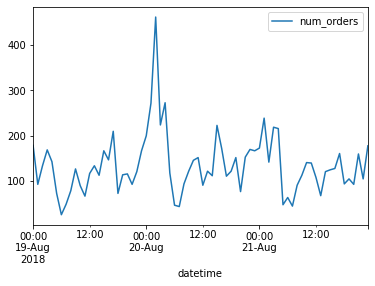

In [16]:
df_1h['2018-08-19':'2018-08-21'].plot()

<AxesSubplot:xlabel='datetime'>

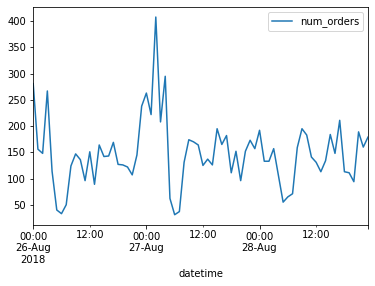

In [17]:
df_1h['2018-08-26':'2018-08-28'].plot()

<AxesSubplot:xlabel='datetime'>

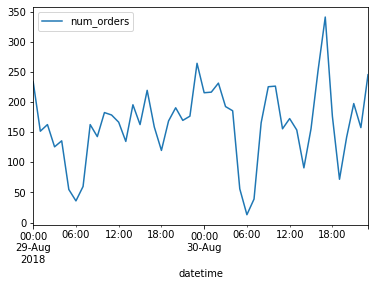

In [18]:
df_1h['2018-08-29':'2018-08-30'].plot()

### Вывод
* Кол-во заказов в целом растет от месяца к месяцу
* Существует тренд на большое кол-во заказов к 00 и наименьшое кол-во заказов в 6 утра
* Рассмотрели выбросы (более 300 заказов в час), большинство из них было в ночь с вскр на пн

## Обучение

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

In [20]:
# Напишем функцию rmse
def rmse(pred, target):
    return np.sqrt(mean_squared_error(pred,target))

In [21]:
df_lr = df_1h.copy()
df_lgb = df_1h.copy()
df_cat = df_1h.copy()

Чтобы оценить порядок авторегрессии, можно построить график частной автокорреляционной функции А для того, чтобы оценить порядок скользящего среднего, построить график автокорреляционной функции. Нам нужен тот параметр, после которого значения функции равны или близки нулю. Подходить может много вариантов, но выбор слишком больших параметров усложнит модель

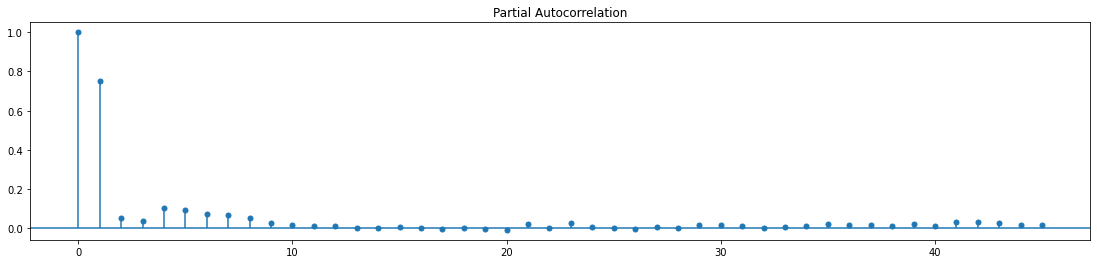

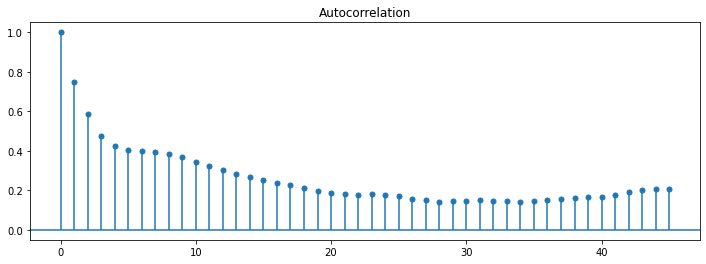

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ts = df['num_orders']
plot_pacf(ts, alpha=None).set_size_inches(19, 4)
plt.show()

plot_acf(ts, alpha=None).set_size_inches(12, 4)
plt.show()

In [23]:
make_features(df_lr, 140, 8)  
        
train, test = train_test_split(df_lr, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']

X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

### LinearRegression

```python
best_rmse_lr = 1000  
best_lag_lr = 0  
best_rol_lr = 0  
for lag in range(1, 150 ,5):  
    for rol in range(1,10, 2):  
        make_features(df_lr, lag, rol)  
        
        train_lr, test_lr = train_test_split(df_lr, shuffle=False, test_size=0.1)
        train_lr = train_lr.dropna()

        X_train_lr = train_lr.drop(['num_orders'], axis=1)
        y_train_lr = train_lr['num_orders']

        X_test_lr = test_lr.drop(['num_orders'], axis=1)
        y_test_lr = test_lr['num_orders']
        
        param_search = {}
        
        model = LinearRegression()
        tscv = TimeSeriesSplit(n_splits=2)
        gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search)
        gsearch.fit(X_train_lr, y_train_lr)

        pred_lr = gsearch.predict(X_train_lr)
        result_lr = rmse(pred_lr, y_train_lr)
        
        if result_lr < best_rmse_lr:
            best_rmse_lr = result_lr
            best_lag_lr = lag
            best_rol_lr = rol
        
        
print(best_rmse_lr, best_lag_lr, best_rol_lr)
```

In [24]:
param_search = {}
        
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=2)
gsearch = RandomizedSearchCV(estimator=model, cv=tscv, param_distributions=param_search)
gsearch.fit(X_train, y_train)

pred_lr = gsearch.predict(X_train)
result_lr = rmse(pred_lr, y_train)
result_lr 

21.6751173921276

### LightGBM

```python
best_rmse_lgb = 1000  
best_lag_lgb = 0  
best_rol_lgb = 0  
for lag in range(1, 150,5):  
    for rol in range(1,10, 1):  
        make_features(df_lgb, lag, rol)  
        
        train_lgb, test_lgb = train_test_split(df_lgb, shuffle=False, test_size=0.1)
        train_lgb = train_lgb.dropna()

        X_train_lgb = train_lgb.drop(['num_orders'], axis=1)
        y_train_lgb = train_lgb['num_orders']

        X_test_lgb = test_lgb.drop(['num_orders'], axis=1)
        y_test_lgb = test_lgb['num_orders']
        
        model = LGBMRegressor()
        param_search = {}
        
        tscv = TimeSeriesSplit(n_splits=2)
        gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search)
        gsearch.fit(X_train_lgb, y_train_lgb)

        pred_lgb = gsearch.predict(X_train_lgb)
        result_lgb = rmse(pred_lgb, y_train_lgb)
        
        if result_lgb < best_rmse_lgb:
            best_rmse_lgb = result_lgb
            best_lag_lgb = lag
            best_rol_lgb = rol
        
        
print(best_rmse_lgb, best_lag_lgb, best_rol_lgb)
```

In [25]:
model = LGBMRegressor()
param_search = {}
        
tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search)
gsearch.fit(X_train, y_train)

pred_lgb = gsearch.predict(X_train)
result_lgb = rmse(pred_lgb, y_train)
result_lgb

9.241798275106659

### Вывод
* Мы подобрали параметры лага и временной скользящей на линейной регрессии и lgbm
* Лучшие результаты показали лаг - 140, скользящая средняя - 8
* Лучше всего модель сработала на lgbm на тренировочной выборке результат 9.24

## Тестирование

In [28]:
param_search = {}
        
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=2)
gsearch = RandomizedSearchCV(estimator=model, cv=tscv, param_distributions=param_search, scoring = 'neg_mean_squared_error')
gsearch.fit(X_test, y_test)
pred_lr = gsearch.predict(X_test)
result_lr = rmse(pred_lr, y_test)
result_lr

32.43695677233

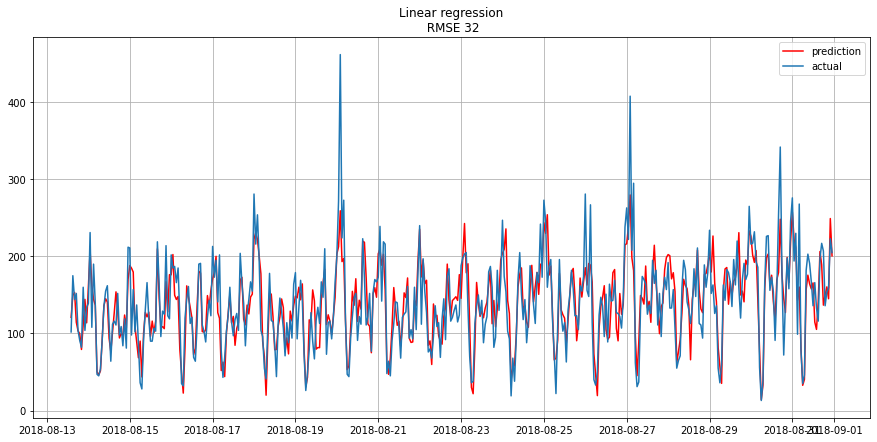

In [29]:
plt.figure(figsize=(15, 7))
plt.plot(X_test.index, pred_lr, "r", label="prediction")
plt.plot(X_test.index, y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n RMSE {}".format(round(result_lr)))
plt.grid(True);

In [30]:
lgb_model = LGBMRegressor()
lgb_model.fit(X_train,y_train, verbose=False)
pred_lgb = lgb_model.predict(X_test)
result_lgb = rmse(pred_lgb, y_test)
print('RMSE is {}'.format(result_lgb))

RMSE is 37.572128965908604


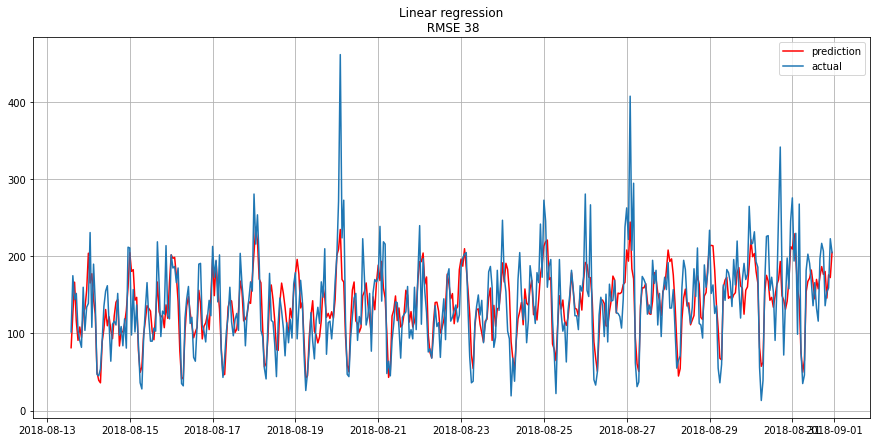

In [31]:
plt.figure(figsize=(15, 7))
plt.plot(X_test.index, pred_lgb, "r", label="prediction")
plt.plot(X_test.index, y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n RMSE {}".format(round(result_lgb)))
plt.grid(True);

In [32]:
%time
cat= CatBoostRegressor()
cat.fit(X_train,y_train,verbose=False)
pred_cat = cat.predict(X_test)
result_cat = rmse(pred_cat, y_test)
print('RMSE is {}'.format(result_cat))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs
RMSE is 37.64170597606008


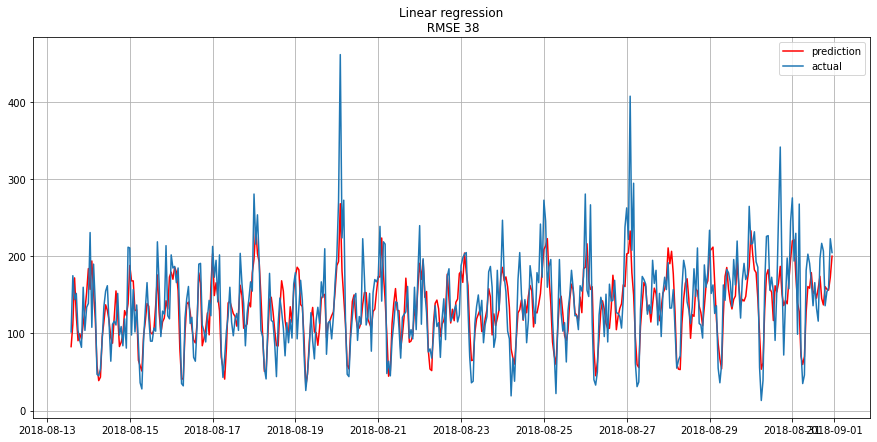

In [33]:
plt.figure(figsize=(15, 7))
plt.plot(X_test.index, pred_cat, "r", label="prediction")
plt.plot(X_test.index, y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n RMSE {}".format(round(result_cat)))
plt.grid(True);

### Вывод
* Лучший результат на тестовой выборке показал catboost = 37.64, lgbm = 37.57, лин. рег = 32.43

### Общий вывод
Анализ данных:
* В датасете временной ряд начинается с 1 марта 2018 и оканчивается 31 августа 2018
* Данные расположены в хронологическом порядке, длина интервала равна 10 минутам
* Временной ряд был принят за индекс
* Пропуски отсутствуют
* Кол-во заказов в целом растет от месяца к месяцу
* Существует тренд на большое кол-во заказов к 00 и наименьшое кол-во заказов в 6 утра
* Рассмотрели выбросы (более 300 заказов в час), большинство из них было в ночь с вскр на пн

Работа с моделями
* Мы подобрали параметры лага и временной скользящей на линейной регрессии и lgbm
* Лучшие результаты показали лаг - 140, скользящая средняя - 8
* Лучше всего модель сработала на lgbm на тренировочной выборке результат 9.24
* Лучший результат на тестовой выборке показал catboost = 37.64, lgbm = 37.57, лин. рег = 32.43